# Fitting germanium detector efficiencies
---
---
This code gives an example of efficiency fitting for a HPGe detector. It discusses the differences between a conventional least-square fitting approach (using *statsmodels*) and a Bayesian approach (using *pymc*). The former has several caveats that are solved by Bayesian methods.

Rather than fitting the efficiency itself, the natural logarithm of the efficiency is typically fitted. By doing this, our fit function becomes
$$ln(\varepsilon) = \sum_{i=0}^{N} a_i \, ln(E/E_0)^i,$$

where $a_i$ are the fit parameters, and $N$ is a user-defined cutoff level, and $E_0$ is a scaling energy. As discussed later in this notebook, there are several benefits to rescale the energy in the fit function. This changes the physical meaning of the fit parameters $a_i$, but as we are only interested in a descriptive model, we don't care about this physical meaning. A regular standardization and zero-point shift is not applicable, as logarithms of negative values creep into the fitting model.

One should note that when talking about activities, the positioning of the source comes into play as well. Small shifts in position can very the "effective activity". In this work, we assume the source positioning remains identical.

## Initial setup
---
import packages

In [1]:
# General functionalities
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

# uncertainty utility
import uncertainties
from uncertainties import ufloat as uf
from uncertainties import unumpy as unp

# Custom utility
from __plotUtility__ import *
from __fitUtility__ import *
from __traceUtility__ import *

Load in data

In [2]:
# File headers: Source, A, A_err E E_err I I_err C C_err time
# Units: energies in keV; times in s; counts in absolute; mean and std in uncalibrated channels
Sources = ['56Co', '137Cs', '133Ba', '152Eu']
keys = ['source', 'A', 'A_err', 'E', 'E_err', 'I', 'I_err', 'C', 'C_err', 't']
dictData = {}

directory = "data/"

for source in Sources:
    dictData[source] = pd.read_csv(directory + "Fitresults_" + source + ".txt", header=0, names=keys, sep = ' ')

In [3]:
# Source : [activity, activity relative uncertainty] in Bq
activities = {
    '56Co'  : uf(dictData['56Co']['A'][0], dictData['56Co']['A_err'][0]),
    '133Ba' : uf(dictData['133Ba']['A'][0], dictData['133Ba']['A_err'][0]),
    '152Eu' : uf(dictData['152Eu']['A'][0], dictData['152Eu']['A_err'][0]),
    '137Cs' : uf(dictData['137Cs']['A'][0], dictData['137Cs']['A_err'][0])
}

# Plot points from a different source with different markers and colors
markers = {
    '56Co'  : 'o',
    '133Ba' : 'v',
    '152Eu' : '*',
    '137Cs' : 'x'
}

markersizes = {
    '56Co'  : 6,
    '133Ba' : 8,
    '152Eu' : 8,
    '137Cs' : 8
}

colors = {
    '56Co'  : 'tab:blue',
    '133Ba' : 'tab:orange',
    '152Eu' : 'tab:green',
    '137Cs' : 'tab:pink'
}

plotSettings = {
    'markers'     : markers,
    'markersizes' : markersizes,
    'colors'      : colors
}

Concat data

In [4]:
# Scale counts to time, intensity, and activity (efficiency in ratio of 1)
columns = ['E', 'E_err', 'C', 'C_err', 'A', 'A_err', 'Intensity', 't', 'source']
data = pd.DataFrame(columns = columns)

for source in Sources:
    # Error propagation log(x) --> d(log(x)) = dx/x (assuming relative error is < 10% or so)
    dictData[source]['logC']     = np.log(dictData[source]['C'])
    dictData[source]['logC_err'] = dictData[source]['C_err']/dictData[source]['C']
    
    for index in range(len(dictData[source])):
        entry = {
            'E'        : dictData[source]['E'][index],
            'E_err'    : dictData[source]['E_err'][index],
            'C'        : dictData[source]['C'][index],
            'C_err'    : dictData[source]['C_err'][index],
            'logC'     : dictData[source]['logC'][index],
            'logC_err' : dictData[source]['logC_err'][index],

            'A'        : activities[source].n,
            'A_err'    : activities[source].s,
            'Intensity': dictData[source]['I'][index],
            't'        : dictData[source]['t'][index],
            'source'   : source
        }

        # Supresses warning of concating empty dataframe
        if (len(data) == 0):
            data = pd.DataFrame(entry, columns = columns, index=[0])
        else:
            data = pd.concat([data, pd.DataFrame([entry], columns=data.columns)], ignore_index=True)

Calculate efficiency and log efficiency

In [5]:
data['eff']         = data['C'] / (data['t'] * data['Intensity'] * data['A'])
data['logeff']      = np.log(data['eff'])
data['eff_staterr'] = data['eff'] * (data['C_err']/data['C'])
data['eff_syserr']  = data['eff'] * (activities[source].s/activities[source].n)
data['eff_err']     = np.sqrt(data['eff_staterr']**2 + data['eff_syserr']**2)
data['logeff_err']  = data['eff_err']/data['eff']

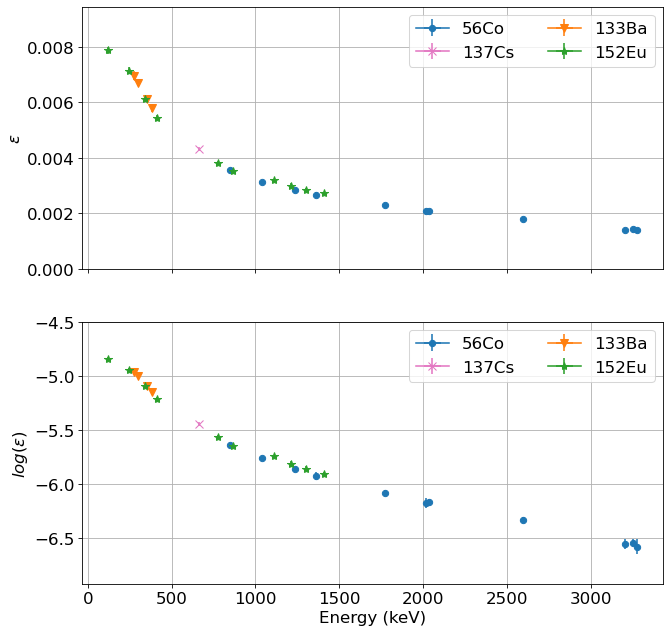

In [6]:
fitDict = {'show': False, 'xvals': 0, 'yvals': 0, 'lower': 0, 'upper': 0}

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
plot_eff(ax[0], data, fitDict, plotSettings, legendCol=2)
plot_logEff(ax[1], data, fitDict, plotSettings, legendCol=2)
ax[0].set_xlabel("")
plt.show()

## Effect of scaling on statsmodels fits
---
First, let's evaluate the benefit of scaling the data. Different scaling factors will be used on the same data sets and the correlation and condition numbers can be compared. Unscaled data is simply setting the scaling factor to one. For simplicity, the fit model is truncated at N=2.

In [7]:
order = 2 # Max exponent of log(E) in the model

scalingFactors    = [1, 10, 100, 500, 1000, 5000]
fitResultsScaling = [None] * len(scalingFactors)

for index, scaling in enumerate(scalingFactors):
    model = sm_logmodel(order, scaling=scaling)
    fitResultsScaling[index] = sm.WLS.from_formula(formula=model, data=data, weights=(data['logeff_err'])**(-2)).fit()

In [8]:
for index, scaling in enumerate(scalingFactors):
    print("--------------------------")
    print(f'scaling = {scaling:d}')
    #print(fitResultsScaling[index].summary())
    print(f'R2 = {fitResultsScaling[index].rsquared:.4f}')
    print(f'cond = {fitResultsScaling[index].condition_number:.2f}')

    corrMatrix = sm_help.cov2corr(fitResultsScaling[index].cov_params())
    sumCorr = np.abs(corrMatrix[0][1]) + np.abs(corrMatrix[0][2]) + np.abs(corrMatrix[1][2])
    avgCorr = sumCorr/3

    
    print(f'C(a0, a1) = {corrMatrix[0][1]:.4f}')
    print(f'C(a0, a2) = {corrMatrix[0][2]:.4f}')
    print(f'C(a1, a2) = {corrMatrix[1][2]:.4f}')
    print(f'C avg = {avgCorr:.4f}')

print("--------------------------")

#covMatrix = result1.cov_params()

--------------------------
scaling = 1
R2 = 0.9926
cond = 2507.48
C(a0, a1) = -0.9969
C(a0, a2) = 0.9888
C(a1, a2) = -0.9974
C avg = 0.9944
--------------------------
scaling = 10
R2 = 0.9926
cond = 484.98
C(a0, a1) = -0.9912
C(a0, a2) = 0.9709
C(a1, a2) = -0.9936
C avg = 0.9852
--------------------------
scaling = 100
R2 = 0.9926
cond = 35.95
C(a0, a1) = -0.9115
C(a0, a2) = 0.7981
C(a1, a2) = -0.9679
C avg = 0.8925
--------------------------
scaling = 500
R2 = 0.9926
cond = 2.50
C(a0, a1) = -0.0074
C(a0, a2) = -0.6258
C(a1, a2) = -0.3597
C avg = 0.3310
--------------------------
scaling = 1000
R2 = 0.9926
cond = 3.72
C(a0, a1) = -0.0451
C(a0, a2) = -0.4330
C(a1, a2) = 0.7419
C avg = 0.4067
--------------------------
scaling = 5000
R2 = 0.9926
cond = 51.69
C(a0, a1) = 0.9562
C(a0, a2) = 0.8838
C(a1, a2) = 0.9769
C avg = 0.9390
--------------------------


Introducing a scaling factor reduced the condition number and the correlation between parameters substantially, while the $R^2$ remains identical. While the correlation in the unscaled case indicates a high degree of multicollinearity, it is reduced to easily managable levels for the scaled cases.

By simply scaling our model, which changes the value of parameters, it has become more robust. Without rescaling, small deviations, such as rounding, could suddenly make the model unphysical. For example, the efficiency could become negative or larger than 100%.


## Effect of scaling on Bayesian fit
---

Let's also evaluate what scaling changes in a Bayesian fit. Besides the previously mentioned aspect, the time required for the sampling will change depending on the rescaling factor. 

In a conventional fit, activities are kept fixed and the data points uncorrelated. In a Bayesian approach, we can turn the activities into fit parameters with priors. Priors on the activitiy are taken to be Gaussians with a standard deviation equal to the quoted uncertainty. Rather than fitting $ln(\varepsilon)$, we can fit $ln(C)$. Note that in this example, we neglect the uncertainties originating from the literature intensity and energy, as well as the uncertainty on the length of the measurement. In most applications this is sufficient, but in other cases one can assign a prior to these as well. In order to provide a prior on the parameters of the fitting model $a_i$, an initial fit is made with *statsmodels*. The resulting covariance matrix is multiplied by four (double the standard errors while keeping the same correlation) and set as a multivariate distribution.

In [9]:
order = 2 # Max exponent of log(E) in the model

newTrace = False
nCores   = 1
nChains  = 4
nSteps   = 10000
tracesScaling  = [None] * len(scalingFactors)


print("--------------------------")

for index, scaling in enumerate(scalingFactors):
    print(f'Scaling factor = {scaling:d}')
    nameTrace = f'testScaling_{scaling:04d}'

    tracesScaling[index] = bayesian_fit(data, dictData, activities, Sources, 
                                       nameTrace, newTrace=newTrace, 
                                       order=order, scaling=scaling, 
                                       nCores=nCores, nChains=nChains, nSteps=nSteps)
    print("--------------------------")

--------------------------
Scaling factor = 1
--------------------------
Scaling factor = 10
--------------------------
Scaling factor = 100
--------------------------
Scaling factor = 500
--------------------------
Scaling factor = 1000
--------------------------
Scaling factor = 5000
--------------------------


In some cases, these are not enough samples to gives good results, as can be seen in the traces below. However, this is simply to show the differences in sampling speed with different rescaling factors.

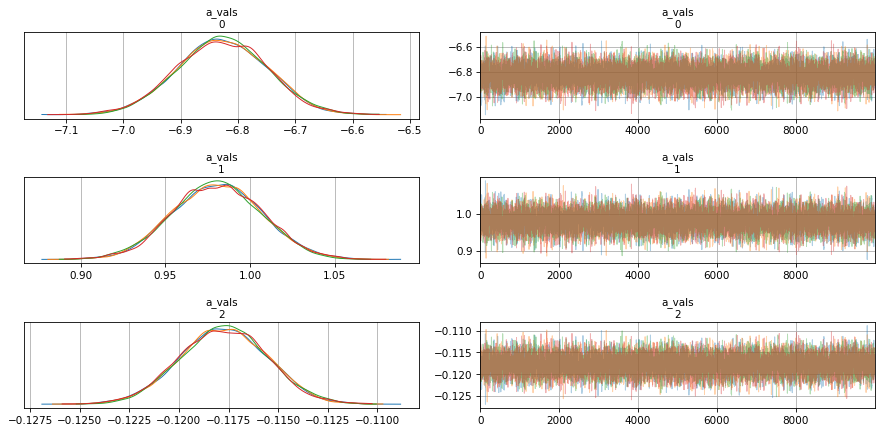

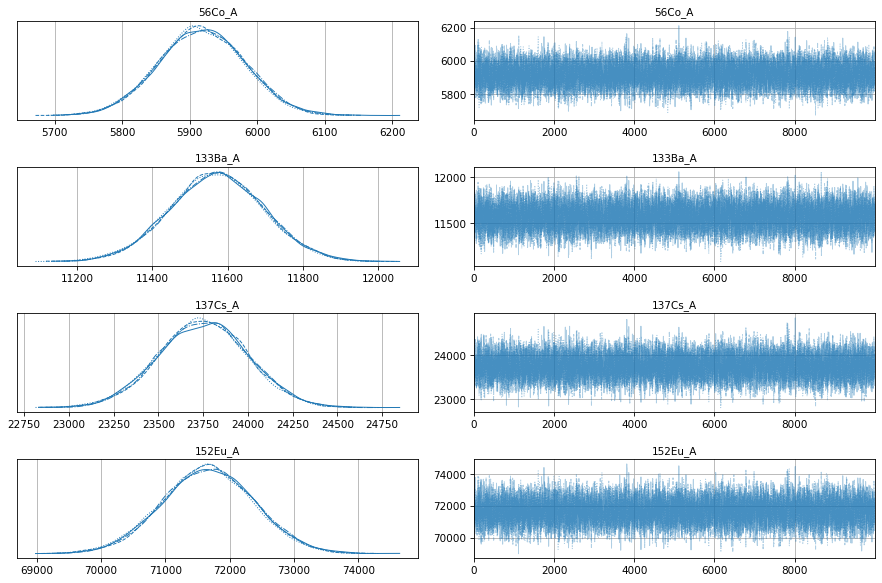

In [10]:
ax = az.plot_trace(tracesScaling[0], var_names=['a_vals'], compact=False)
plt.tight_layout()
plt.show()

ax = az.plot_trace(tracesScaling[0], var_names=['56Co_A', '133Ba_A', '137Cs_A', '152Eu_A'])
plt.tight_layout()
plt.show()

Run time depends on the device, but on my device the following run times occur

In [11]:
runTimesSeconds = [17*60 + 34, 8*60+59, 4*60+36, 4*60+14, 4*60 + 18, 5*60+58]

for index, scaling in enumerate(scalingFactors):
    print("--------------------------")
    print(f'scaling = {scaling:d}')
    print(f'runtime = {runTimesSeconds[index]:d} s')
    print(f'relative = {runTimesSeconds[index]/runTimesSeconds[3]:f}')

print("--------------------------")

--------------------------
scaling = 1
runtime = 1054 s
relative = 4.149606
--------------------------
scaling = 10
runtime = 539 s
relative = 2.122047
--------------------------
scaling = 100
runtime = 276 s
relative = 1.086614
--------------------------
scaling = 500
runtime = 254 s
relative = 1.000000
--------------------------
scaling = 1000
runtime = 258 s
relative = 1.015748
--------------------------
scaling = 5000
runtime = 358 s
relative = 1.409449
--------------------------


Clearly, using a scaling factor also reduces the required runtime for the same length chains. This is because the acceptance in sampling increases as the correlation reduces. This becomes even more parametric if we increase $N$ to 3. We can also compare the corner plots between the different scalings.

--------------------------
scaling = 1


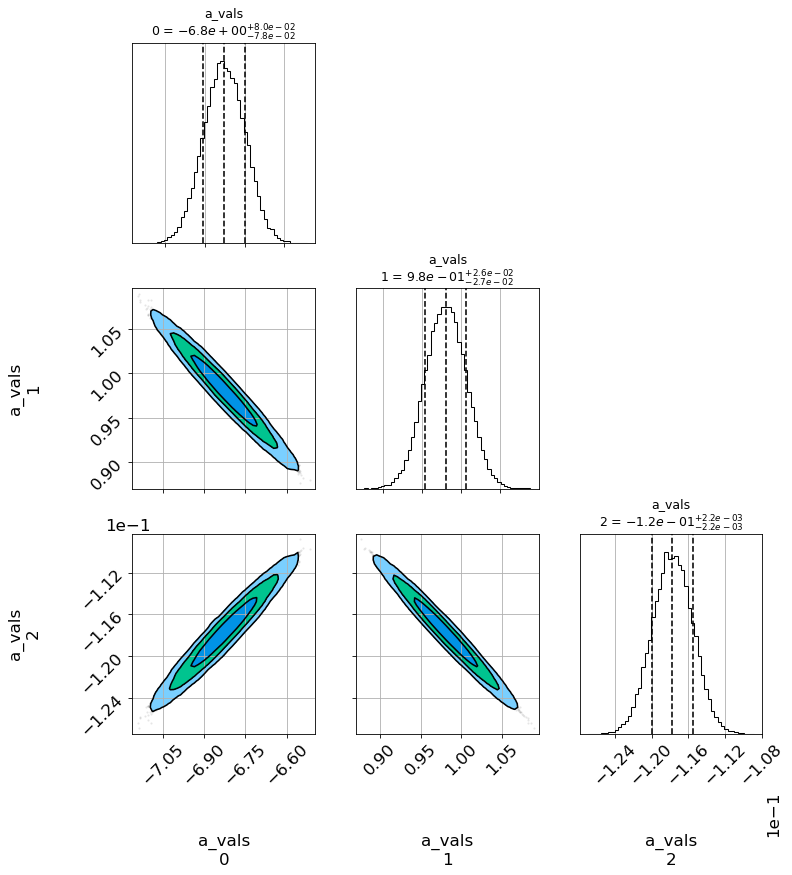

--------------------------
scaling = 500


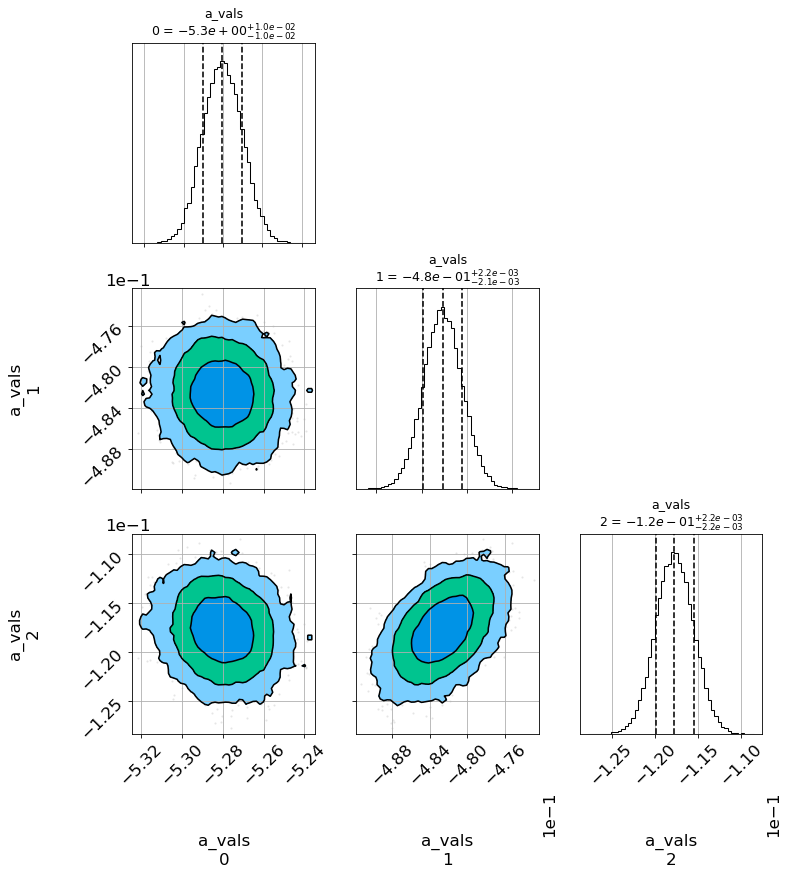

--------------------------


In [12]:
print("--------------------------")
print(f'scaling = {scalingFactors[0]:d}')
corner_plot(tracesScaling[0], ['a_vals'], 3)
#plt.savefig("images/corner_unscaled.pdf")
plt.show()
print("--------------------------")
print(f'scaling = {scalingFactors[3]:d}')
corner_plot(tracesScaling[3], ['a_vals'], 3)
#plt.savefig("images/corner_scaled.pdf")
plt.show()
print("--------------------------")

As expected from the statsmodels results, a transition is made from a highly multicollinear situation towards lowly correlated values with substantially lower relative uncertainties.

### General performance
---
Since $E_0 = 500$keV provides the best condition number, we choose this for the scaling energy for the remainder of this work. Now, we will compare a statsmodels fit and a pymc fit to highlight the differences in performance. We also now truncate the model at N=4 to catch more subtle details of the efficiency response function.

Let's begin with a simple statsmodels fit

In [13]:
order = 4
scaling = 500
nLinspace = 100
E_linspace = np.linspace(100, 3350, nLinspace)


model = sm_logmodel(order, scaling=scaling)
smFit = sm.WLS.from_formula(formula=model, data=data, weights=(data['logeff_err'])**(-2)).fit()
smPrediction = sm_predict(E_linspace, smFit, scaling=scaling, uncertainty=True)

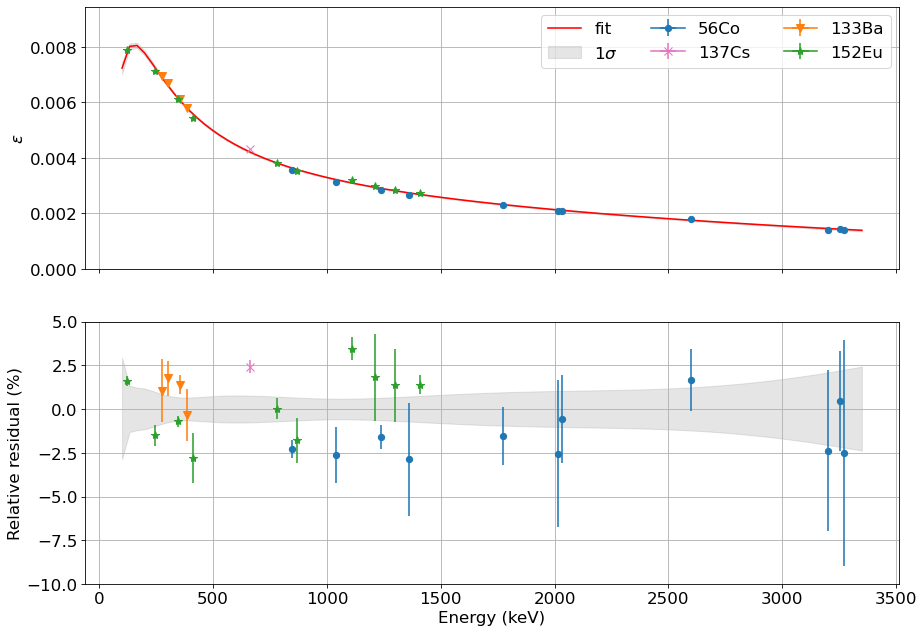

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fitDict = {'show': True, 'xvals': E_linspace, 'yvals': np.exp(smPrediction[0]), 
           'lower': np.exp(smPrediction[1]), 'upper': np.exp(smPrediction[2])}

temp_data = copy.deepcopy(data)
temp_data['eff_err'] = data['eff'] * (data['C_err']/data['C'])

plot_eff(ax[0], temp_data, fitDict, plotSettings)
plot_relResid_eff(ax[1], temp_data, fitDict, plotSettings, legendLoc="upper left")

ax[0].set_xlabel("")
ax[1].set_ylim([-10, 5])
plt.savefig("images/eff_leastsq.pdf")
plt.show()

It seems that the predicted uncertainty does not fully capture the residuals produced by the fit.

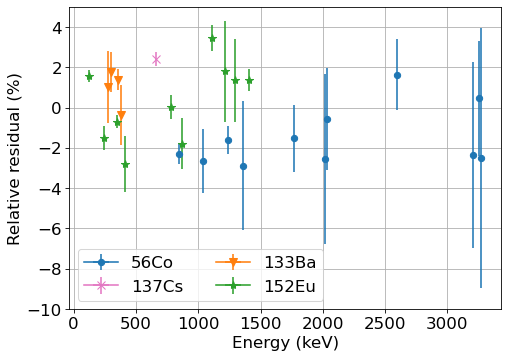

In [15]:
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)


fitDict = {'show': False, 'xvals': E_linspace, 'yvals': np.exp(smPrediction[0]), 
           'lower': np.exp(smPrediction[1]), 'upper': np.exp(smPrediction[2])}
plot_relResid_eff(ax, temp_data, fitDict, plotSettings, legendLoc="upper left")
ax.legend(ncol=2, loc='lower left')
ax.set_ylim(-10, 5)
plt.tight_layout()
plt.savefig("images/RelResid_LeastSq.pdf")
plt.show()

The relative residuals seem to be grouped by calibration source. This is because the leading uncertainty originates from the activity of the source. Hence, all points are shifted by a constant factor.

Let's now also try the Bayesian approach

In [16]:
nCores   = 1
nChains  = 4
nSteps   = 10000
newTrace = False

nameTrace = f'fitOrder4'

trace = bayesian_fit(data, dictData, activities, Sources, 
                     nameTrace, newTrace=newTrace, order=order, scaling=scaling, 
                     nCores=nCores, nChains=nChains, nSteps=nSteps)

Plot the traces and cornerplots to see if everything went well

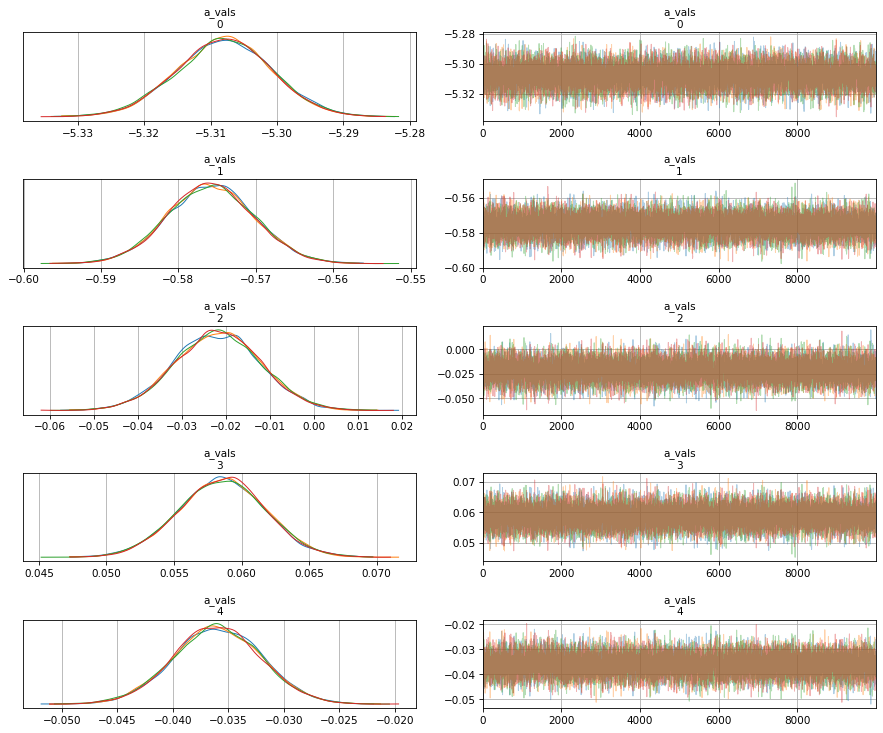

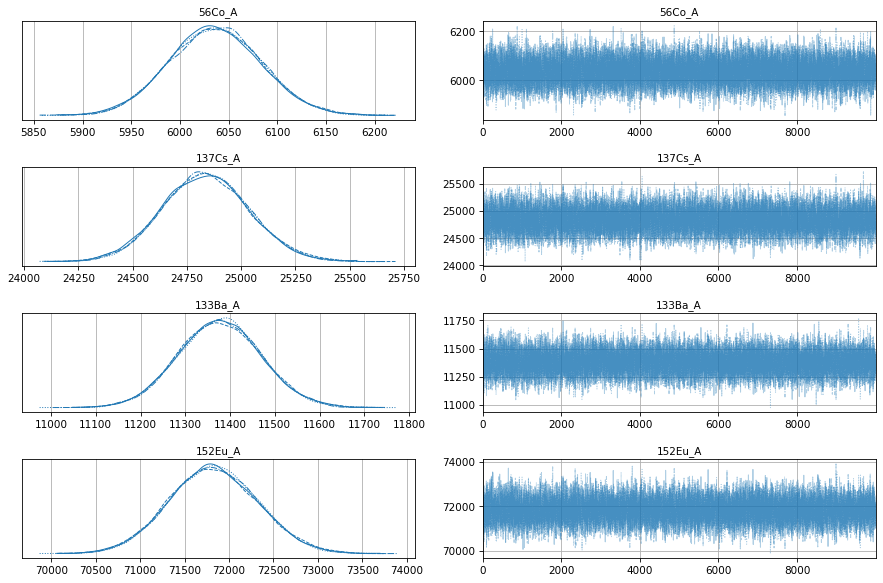

In [17]:
ax = az.plot_trace(trace, var_names=['a_vals'], compact=False)
plt.tight_layout()
plt.show()

ax = az.plot_trace(trace, var_names=['56Co_A', '137Cs_A', '133Ba_A', '152Eu_A'])
plt.tight_layout()
plt.show()

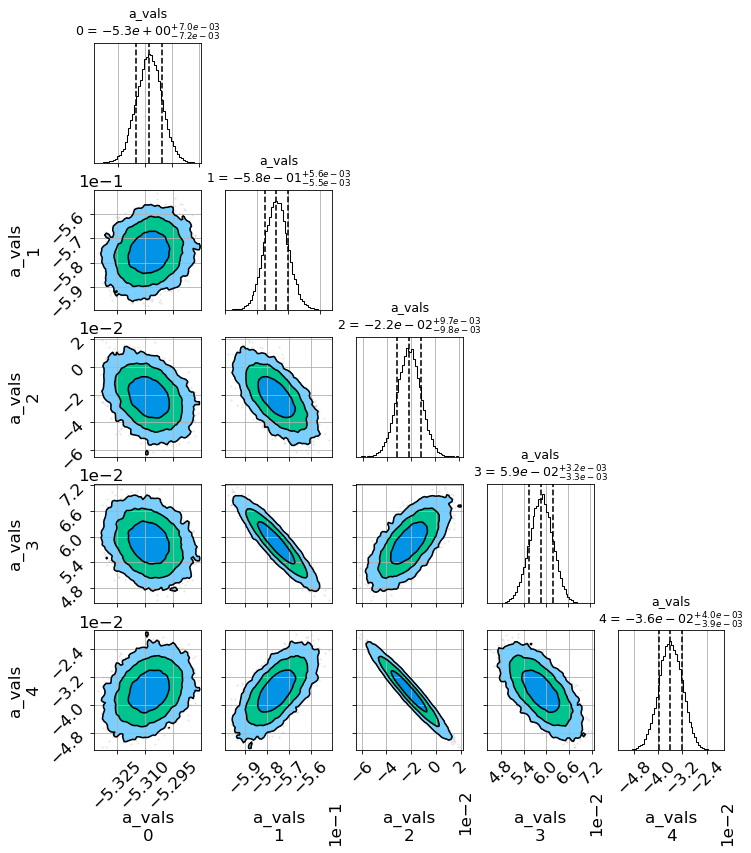

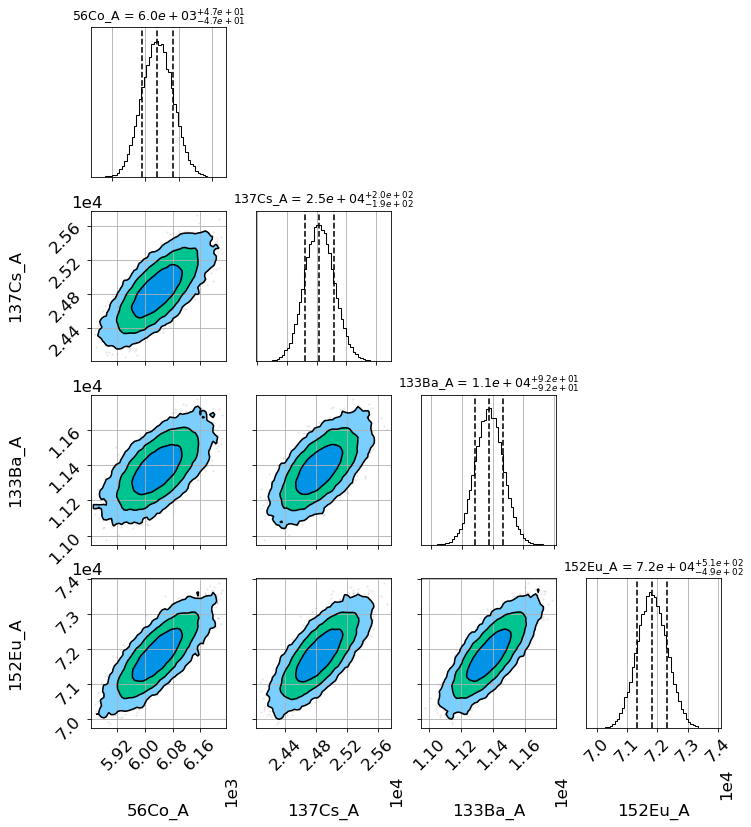

In [18]:
corner_plot(trace, ['a_vals'], 5)
plt.savefig("images/corner_avals.pdf")
corner_plot(trace, ['56Co_A', '137Cs_A', '133Ba_A', '152Eu_A'], 4)
plt.savefig("images/corner_activities.pdf")

Now extract the median activities from the sampling process and the 1 sigma quantiles.

In [19]:
bayesianMedian, bayesianConfNeg, bayesianConfPos = trace_to_predict(trace, E_linspace, order=order, scaling=scaling)
bayesianA = trace_to_activity(trace, Sources)

We can evaluate how different the extracted activities are compared to the quoted ones

In [20]:
A_ratio = {}

for source in Sources:
    A_ratio[source] = bayesianA[source][0]/activities[source].n
    error = bayesianA[source][1]/activities[source].n
    
    print(f'Activity ratio {source}: {A_ratio[source]:.3f} +/- {error:.3f}')

Activity ratio 56Co: 0.971 +/- 0.008
Activity ratio 137Cs: 1.024 +/- 0.008
Activity ratio 133Ba: 1.023 +/- 0.008
Activity ratio 152Eu: 1.002 +/- 0.007


We can use the activities from the output of the Bayesian analysis to recalculate the efficiencies for visualization purposes. Since the activities are themselves fit parameters, I only show statistical uncertainties from the count rates in the plots below.

In [21]:
data['recalc_eff']     = np.zeros(len(data))
data['recalc_eff_err'] = np.zeros(len(data))

# Shift the efficiencies according to the ratio of the quoted and new activities
for index in range(len(data)):
    data.loc[index, 'recalc_eff']     = data['eff'][index] / A_ratio[data['source'][index]]
    data.loc[index, 'recalc_eff_err'] = data['eff_staterr'][index] / A_ratio[data['source'][index]]

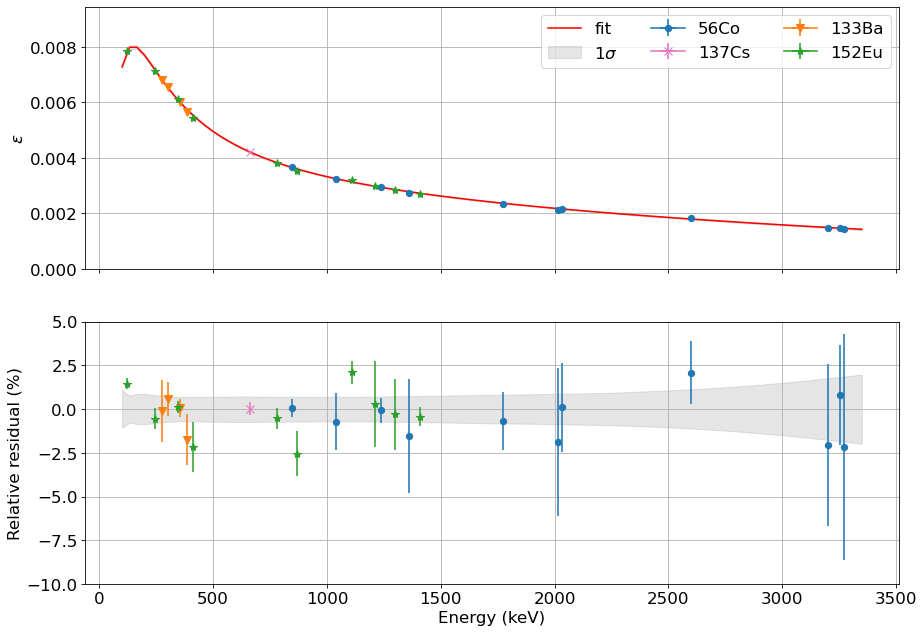

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fitDict = {'show': True, 'xvals': E_linspace, 'yvals': bayesianMedian, 
           'lower': bayesianConfNeg, 'upper': bayesianConfPos}
plot_eff(ax[0], data, fitDict, plotSettings, scaled=True)
plot_relResid_eff(ax[1], data, fitDict, plotSettings, legendLoc="upper left", scaled=True)

ax[0].set_xlabel("")
ax[1].set_ylim([-10, 5])
plt.savefig("images/eff_bayes.pdf")
plt.show()

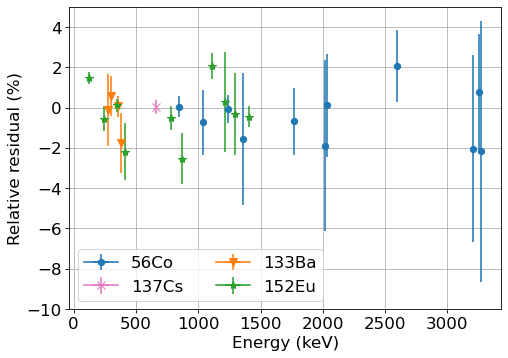

In [23]:
fig, ax = plt.subplots(figsize=(7, 5), sharex=True)

fitDict = {'show': False, 'xvals': E_linspace, 'yvals': bayesianMedian, 
           'lower': bayesianConfNeg, 'upper': bayesianConfPos}

plot_relResid_eff(ax, data, fitDict, plotSettings, legendLoc="upper left", scaled=True)
ax.legend(ncol=2, loc='lower left')
ax.set_ylim(-10, 5)
plt.tight_layout()
plt.savefig("images/RelResid_Bayes.pdf")
plt.show()

The systematic offsets between different sources have been mostly removed. Let's have a look at how much the fitresult differs between two methods.

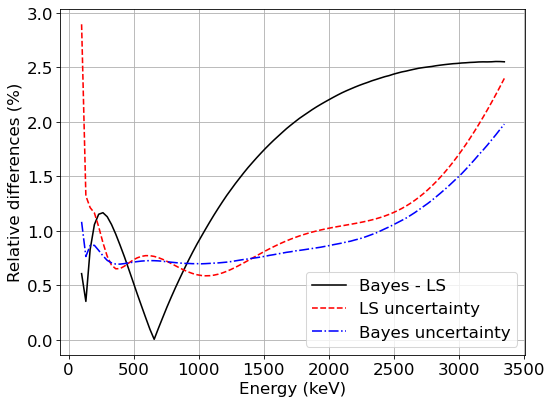

In [24]:
ReldiffMethods = 100 * np.abs(((bayesianMedian - np.exp(smPrediction[0]))/bayesianMedian))

errorSm     = 0.5 * ((np.exp(smPrediction[0]) - np.exp(smPrediction[1])) + (np.exp(smPrediction[2]) - np.exp(smPrediction[0])))
errorBayes  = 0.5 * ((bayesianMedian - bayesianConfNeg) + (bayesianConfPos - bayesianMedian))
relErrSm    = 100 * errorSm / np.exp(smPrediction[0])
relErrBayes = 100 * errorBayes / bayesianMedian


fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot(E_linspace, ReldiffMethods, 'k-', label='Bayes - LS')
ax.plot(E_linspace, relErrSm, 'r--', label='LS uncertainty')
ax.plot(E_linspace, relErrBayes, 'b-.', label='Bayes uncertainty')

ax.set_xlabel("Energy (keV)")
ax.set_ylabel("Relative differences (%)")
ax.legend(loc='best')
plt.savefig("images/reldiff.pdf")
plt.show()

It seems that the model predictions vary significantly from one another. In certain points, the models predict values that differ by more than two standard deviations. This indicates that the Conventional least-square method provides an inaccurate central value and uncertainty estimate.

### Common issues
---

If we use the unscaled efficiency fit, the correlation between the parameters is very large. As a result, rounding the values changes the shape of the efficiency fit drastically. We start by making a least-square fit without scaling and plot the rounded and exact solutions.

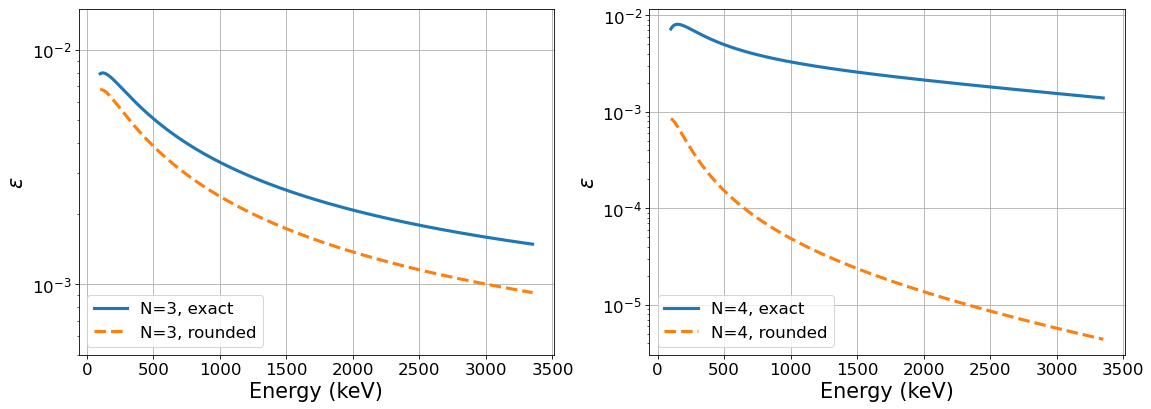

In [25]:
def approx_nominal(my_uf):
    formatted = str(my_uf)

    if not ("e" in formatted):
        output = formatted.split("+/-")[0]
    else:
        nominal, exponent = formatted.split("e")
        value, error = nominal.split("+/-")
        
        output = value.strip("(")

    return float(output)




scaling = 1
E_linspace = np.linspace(100, 3350, 300)


order = 3
model = sm_logmodel(order, scaling=scaling)
fitresult = sm.WLS.from_formula(formula=model, data=data, weights=(data['logeff_err'])**(-2)).fit()

par_values = list(fitresult.params)
par_errors = list(fitresult.bse)
a_exact    = np.zeros_like(par_values)
a_approx   = np.zeros_like(par_values)

for index in range(len(par_values)):
    value = uf(par_values[index], par_errors[index])

    a_exact[index]  = value.n
    a_approx[index] = approx_nominal(value)


eff_exact_3  = calc_eff(E_linspace, a_exact, scaling=scaling)
eff_approx_3 = calc_eff(E_linspace, a_approx, scaling=scaling)



order = 4
model = sm_logmodel(order, scaling=scaling)
fitresult = sm.WLS.from_formula(formula=model, data=data, weights=(data['logeff_err'])**(-2)).fit()

par_values = list(fitresult.params)
par_errors = list(fitresult.bse)
a_exact    = np.zeros_like(par_values)
a_approx   = np.zeros_like(par_values)

for index in range(len(par_values)):
    value = uf(par_values[index], par_errors[index])

    a_exact[index]  = value.n
    a_approx[index] = approx_nominal(value)


eff_exact_4  = calc_eff(E_linspace, a_exact, scaling=scaling)
eff_approx_4 = calc_eff(E_linspace, a_approx, scaling=scaling)




fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

ax[0].plot(E_linspace, eff_exact_3, '-', linewidth=3, label='N=3, exact')
ax[0].plot(E_linspace, eff_approx_3, '--', linewidth=3, label='N=3, rounded')
ax[1].plot(E_linspace, eff_exact_4, '-', linewidth=3, label='N=4, exact')
ax[1].plot(E_linspace, eff_approx_4, '--', linewidth=3, label='N=4, rounded')
ax[0].semilogy()
ax[1].semilogy()
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[0].set_ylim(0.5e-3, 1.5e-2)


ax[0].set_xlabel("Energy (keV)", size=20)
ax[1].set_xlabel("Energy (keV)", size=20)
ax[0].set_ylabel(r'$\varepsilon$', size=20)
ax[1].set_ylabel(r'$\varepsilon$', size=20)
plt.savefig("images/rounding.pdf")
plt.show()

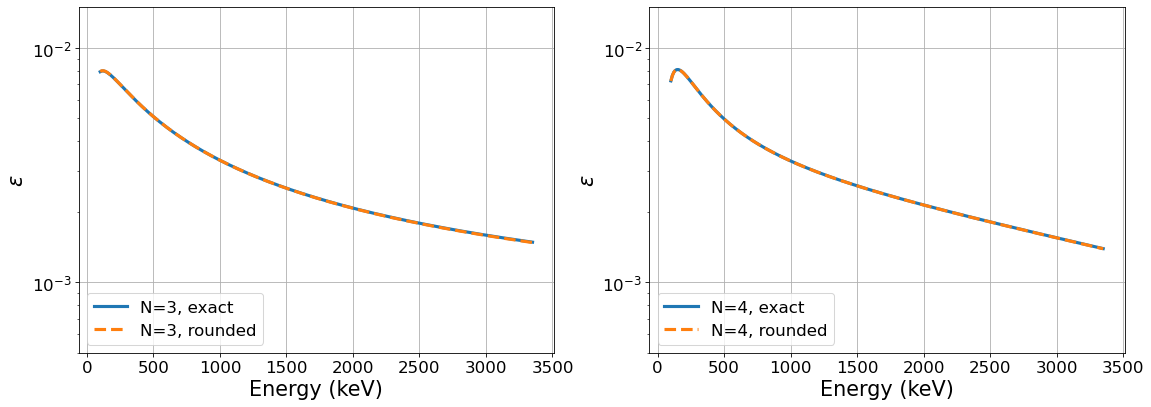

In [26]:
scaling = 500
E_linspace = np.linspace(100, 3350, 300)


order = 3
model = sm_logmodel(order, scaling=scaling)
fitresult = sm.WLS.from_formula(formula=model, data=data, weights=(data['logeff_err'])**(-2)).fit()

par_values = list(fitresult.params)
par_errors = list(fitresult.bse)
a_exact    = np.zeros_like(par_values)
a_approx   = np.zeros_like(par_values)

for index in range(len(par_values)):
    value = uf(par_values[index], par_errors[index])

    a_exact[index]  = value.n
    a_approx[index] = approx_nominal(value)


eff_exact_3  = calc_eff(E_linspace, a_exact, scaling=scaling)
eff_approx_3 = calc_eff(E_linspace, a_approx, scaling=scaling)



order = 4
model = sm_logmodel(order, scaling=scaling)
fitresult = sm.WLS.from_formula(formula=model, data=data, weights=(data['logeff_err'])**(-2)).fit()

par_values = list(fitresult.params)
par_errors = list(fitresult.bse)
a_exact    = np.zeros_like(par_values)
a_approx   = np.zeros_like(par_values)

for index in range(len(par_values)):
    value = uf(par_values[index], par_errors[index])

    a_exact[index]  = value.n
    a_approx[index] = approx_nominal(value)


eff_exact_4  = calc_eff(E_linspace, a_exact, scaling=scaling)
eff_approx_4 = calc_eff(E_linspace, a_approx, scaling=scaling)




fig, ax = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

ax[0].plot(E_linspace, eff_exact_3, '-', linewidth=3, label='N=3, exact')
ax[0].plot(E_linspace, eff_approx_3, '--', linewidth=3, label='N=3, rounded')
ax[1].plot(E_linspace, eff_exact_4, '-', linewidth=3, label='N=4, exact')
ax[1].plot(E_linspace, eff_approx_4, '--', linewidth=3, label='N=4, rounded')
ax[0].semilogy()
ax[1].semilogy()
ax[0].legend(loc='lower left')
ax[1].legend(loc='lower left')
ax[0].set_ylim(0.5e-3, 1.5e-2)
ax[1].set_ylim(0.5e-3, 1.5e-2)


ax[0].set_xlabel("Energy (keV)", size=20)
ax[1].set_xlabel("Energy (keV)", size=20)
ax[0].set_ylabel(r'$\varepsilon$', size=20)
ax[1].set_ylabel(r'$\varepsilon$', size=20)
plt.savefig("images/rounding_scaled.pdf")
plt.show()

Clearly, rounding the values using conventional rounding rules for errors induces large deviations compared to the exact numerical values. This effect is enhanced with larger $N$, as more correlated values are added to the model.

### Relative efficiencies
---
In the Bayesian approach, one keeps the full correlations in the samples. Besides retaining the full probability distribution, this gives access to other operations on the data, such as efficiency ratios. Since the dominant error in the fit originates from a global uncertainty on the activities, the relative efficiency can have a substantially lower uncertainty. In this section, we show the effect of calculating the efficiency as a function of energy, relative to the efficiency at 1 MeV.

In [27]:
nameTrace  = f'fitOrder4'
refEnergy  = 1000
nLinspace  = 100
E_linspace = np.linspace(100, 3350, nLinspace)

RelEffMedian, RelEffConfNeg, RelEffConfPos, refEff = bayes_relative_efficiency(E_linspace, refEnergy, nameTrace, scaling=scaling)

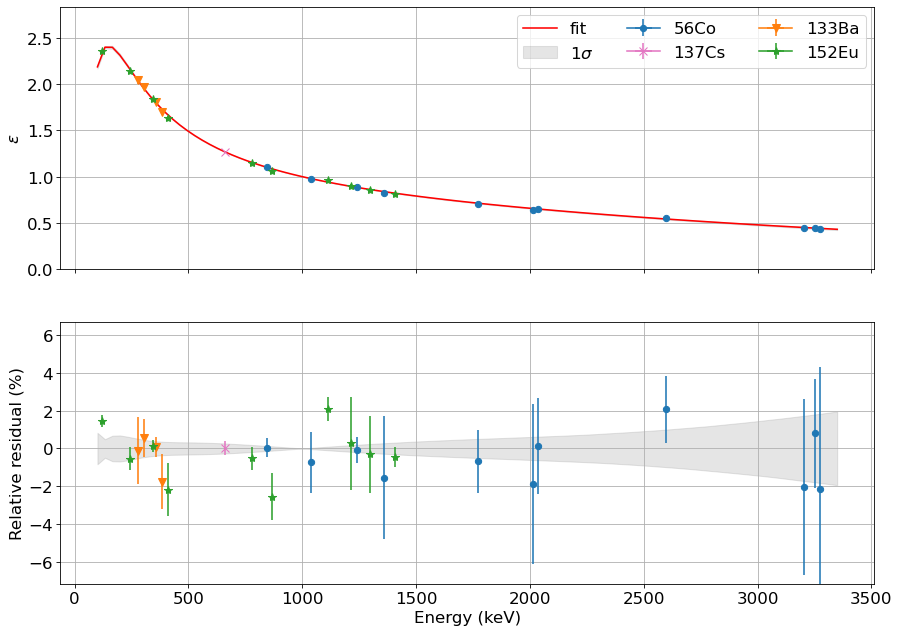

In [28]:
scaledData = copy.copy(data)
scaledData['eff']            = data['eff'] / refEff
scaledData['eff_err']        = data['eff_err'] / refEff
scaledData['recalc_eff']     = data['recalc_eff'] / refEff
scaledData['recalc_eff_err'] = data['recalc_eff_err'] / refEff


fig, ax = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

fitDict = {'show': True, 'xvals': E_linspace, 'yvals': RelEffMedian, 
           'lower': RelEffConfNeg, 'upper': RelEffConfPos}

plot_eff(ax[0], scaledData, fitDict, plotSettings, scaled=True)
plot_relResid_eff(ax[1], scaledData, fitDict, plotSettings, legendLoc="upper left", scaled=True)

ax[0].set_xlabel("")
plt.savefig("images/eff_relative.pdf")
plt.show()

Given the statistics on this particular dataset, the uncertainty band seems to provide an accurate estimate on the relative efficiency. One should however be careful, as this uncertainty band assumes that the model is correct (which is not exactly the case with empirical models). Such a propagation of errors is not possible in least-square fitting, as the required correlations are not taken into account.


### Robustness against anomalous activities
---

During efficiency fitting, it may occur that a source activity does not agree with its quoted values. This often happens when sources are produced with in-house radiochemistry or irradiation, but may also happen to commercial sources. As a result, the fit is not reliable. In this section, we compare the performance of our Bayesian approach in recovering from such an anomalous activity. Furthermore, we evaluate the use of a hyperprior on the sigma of the activity distribution. This allows for an easier "identification" of such anomalous sources.

We will investigate what happens when 1) the 133Ba is moved up by 5 sigma; 2) the 56Co source is moved up by 5 sigma. All while retaining the same relative error on the activities.

In [29]:
def robustness_check(E_linspace, keySource, Sources, activities, data, saveFig = "",
                     order=4, scaling=500, adjustment=5, beta=2,
                     nCores=1, nChains=4, nSteps=5000, newTrace=True):

    # Adjust activities
    ratioChange = 1 + 5*(activities[keySource].s/activities[keySource].n)
    adjustedActivities = copy.copy(activities)
    adjustedActivities[keySource] = uf(ratioChange * activities[keySource].n, ratioChange * activities[keySource].s)

    # Shift efficiency values
    # Errors on logeff don't need to be adjusted as the error on logeff is the relative error on eff (which remains the same)
    adjustedData = copy.copy(data)
    adjustedData.loc[data['source'] == keySource, 'eff'] *= ratioChange
    adjustedData['logeff'] = np.log(adjustedData['eff'])



    # Statsmodels fit
    model = sm_logmodel(order, scaling=scaling)
    # Perform fit with true activity and adjusted activity
    fitResultRef = sm.WLS.from_formula(formula=model, data=data, weights=(data['logeff_err'])**(-2)).fit()
    fitResultAdj = sm.WLS.from_formula(formula=model, data=adjustedData, weights=(data['logeff_err'])**(-2)).fit()
    smPrediction_ref = sm_predict(E_linspace, fitResultRef, scaling=scaling, uncertainty=True)
    smPrediction_adj = sm_predict(E_linspace, fitResultAdj, scaling=scaling, uncertainty=True)
    # Get mean and error on relative deviation
    meanPrediction_ref  = np.zeros_like(smPrediction_ref[0])
    meanPrediction_adj  = (smPrediction_adj[0]/smPrediction_ref[0]) - 1
    errorPrediction_ref = (0.5/smPrediction_ref[0]) * (smPrediction_ref[2] - smPrediction_ref[1])
    errorPrediction_adj = (0.5/smPrediction_adj[0]) * (smPrediction_adj[2] - smPrediction_adj[1])


    # Regular Bayesian fit
    nameTrace = f'fit_regular_unshifted_{keySource}'
    trace_regular_unshifted = bayesian_fit(data, dictData, activities, Sources, 
                                           nameTrace, newTrace=newTrace, order=order, scaling=scaling, 
                                           nCores=nCores, nChains=nChains, nSteps=nSteps, beta=0)
    
    unshifted = trace_to_predict(trace_regular_unshifted, E_linspace, order=order, scaling=scaling)
    
    nameTrace = f'fit_regular_shifted_{keySource}'
    trace_regular_shifted = bayesian_fit(data, dictData, adjustedActivities, Sources,
                                         nameTrace, newTrace=newTrace, order=order, scaling=scaling, 
                                         nCores=nCores, nChains=nChains, nSteps=nSteps, beta=0)
    
    shifted = trace_to_predict(trace_regular_shifted, E_linspace, order=order, scaling=scaling)

    regular_unshifted_value = np.zeros_like(unshifted[0])
    regular_unshifted_error = [(unshifted[1]/unshifted[0]) - 1, (unshifted[2]/unshifted[0]) - 1]
    regular_shifted_value = shifted[0]/unshifted[0] - 1
    regular_shifted_error = [(shifted[1]/unshifted[0]) - 1, (shifted[2]/unshifted[0]) - 1]


    # Hyperprior Bayesian fit
    nameTrace = f'fit_hyperprior_unshifted_{keySource}'
    trace_hyperprior_unshifted = bayesian_fit(data, dictData, activities, Sources, 
                                              nameTrace, newTrace=newTrace, order=order, scaling=scaling, 
                                              nCores=nCores, nChains=nChains, nSteps=nSteps, beta=beta)
    
    unshifted = trace_to_predict(trace_hyperprior_unshifted, E_linspace, order=order, scaling=scaling)
    
    nameTrace = f'fit_hyperprior_shifted_{keySource}'
    trace_hyperprior_shifted = bayesian_fit(data, dictData, adjustedActivities, Sources,
                                            nameTrace, newTrace=newTrace, order=order, scaling=scaling, 
                                            nCores=nCores, nChains=nChains, nSteps=nSteps, beta=beta)
    
    shifted = trace_to_predict(trace_hyperprior_shifted, E_linspace, order=order, scaling=scaling)
    
    hyperprior_unshifted_value = np.zeros_like(unshifted[0])
    hyperprior_unshifted_error = [(unshifted[1]/unshifted[0]) - 1, (unshifted[2]/unshifted[0]) - 1]
    hyperprior_shifted_value = shifted[0]/unshifted[0] - 1
    hyperprior_shifted_error = [(shifted[1]/unshifted[0]) - 1, (shifted[2]/unshifted[0]) - 1]

    # Plot results
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.plot(E_linspace, 100*meanPrediction_adj, color='k', linestyle='-', label='least-squares')
    ax.plot(E_linspace, 100*regular_shifted_value, color='tab:blue', linestyle='--', label='Regular Bayesian')
    ax.plot(E_linspace, 100*hyperprior_shifted_value, color='tab:orange', linestyle=":", label='Hyperprior Bayesian')

    ax.fill_between(E_linspace, 100*regular_shifted_error[0], 100*regular_shifted_error[1], color='tab:blue', alpha=0.2)
    ax.fill_between(E_linspace, 100*hyperprior_shifted_error[0], 100*hyperprior_shifted_error[1], color='tab:orange', alpha=0.2)
    ax.set_xlabel("Energy (keV)")
    ax.set_ylabel("Relative deviation (%)")
    ax.legend(loc='lower left')

    plt.tight_layout()
    if saveFig != "":
        plt.savefig("images/" + saveFig)
    plt.show()

Check 133Ba

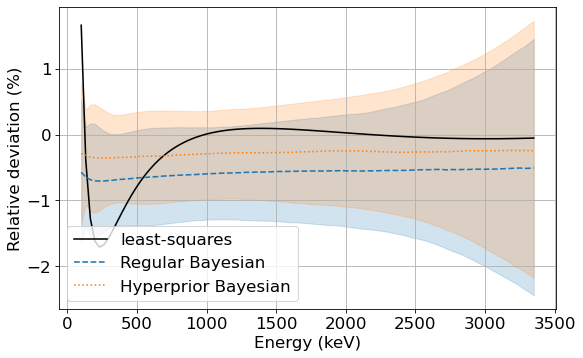

In [30]:
# Moving 133Ba
keySource  = '133Ba'
nLinspace  = 100
E_linspace = np.linspace(100, 3350, nLinspace)

order      = 4
scaling    = 500
adjustment = 5
beta       = 2 # 0.5 standard deviation on sigma_A

nCores   = 1
nChains  = 4
nSteps   = 5000
newTrace = False

robustness_check(E_linspace, keySource, Sources, activities, data, saveFig = "robust_133Ba.pdf",
                 order=order, scaling=scaling, adjustment=adjustment, beta=beta,
                 nCores=nCores, nChains=nChains, nSteps=nSteps, newTrace=newTrace)

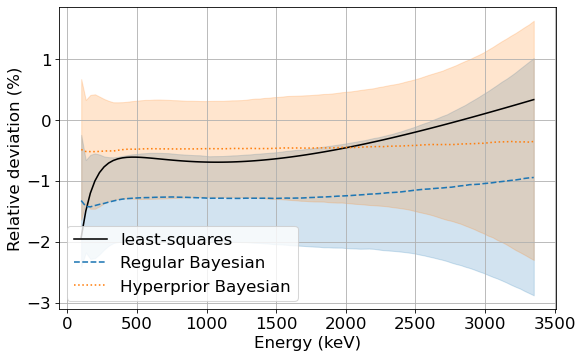

In [31]:
# Moving 152Eu
keySource  = '152Eu'
nLinspace  = 100
E_linspace = np.linspace(100, 3350, nLinspace)

order      = 4
scaling    = 500
adjustment = 5
beta       = 2 # 0.5 standard deviation on sigma_A

nCores   = 1
nChains  = 4
nSteps   = 5000
newTrace = False

robustness_check(E_linspace, keySource, Sources, activities, data, saveFig = "robust_152Eu.pdf",
                 order=order, scaling=scaling, adjustment=adjustment, beta=beta,
                 nCores=nCores, nChains=nChains, nSteps=nSteps, newTrace=newTrace)

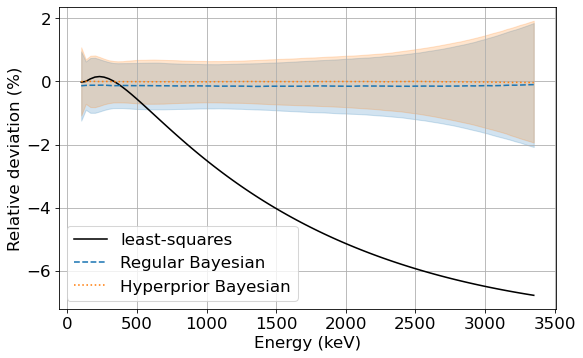

In [32]:
# Moving 56Co
keySource  = '56Co'
nLinspace  = 100
E_linspace = np.linspace(100, 3350, nLinspace)

order      = 4
scaling    = 500
adjustment = 5
beta       = 2 # 0.5 standard deviation on sigma_A

nCores   = 1
nChains  = 4
nSteps   = 5000
newTrace = False

robustness_check(E_linspace, keySource, Sources, activities, data, saveFig = "robust_56Co.pdf",
                 order=order, scaling=scaling, adjustment=adjustment, beta=beta,
                 nCores=nCores, nChains=nChains, nSteps=nSteps, newTrace=newTrace)

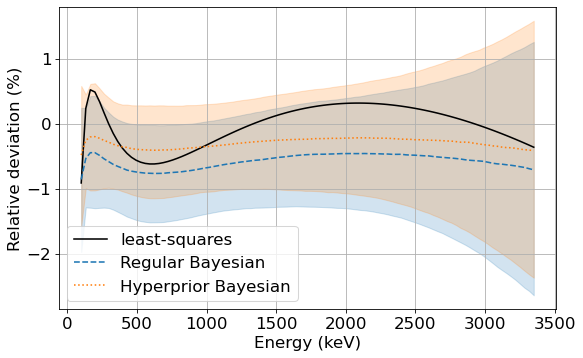

In [33]:
# Moving 137Cs
keySource  = '137Cs'
nLinspace  = 100
E_linspace = np.linspace(100, 3350, nLinspace)

order      = 4
scaling    = 500
adjustment = 5
beta       = 2 # 0.5 standard deviation on sigma_A

nCores   = 1
nChains  = 4
nSteps   = 5000
newTrace = False

robustness_check(E_linspace, keySource, Sources, activities, data, saveFig = "robust_137Cs.pdf",
                 order=order, scaling=scaling, adjustment=adjustment, beta=beta,
                 nCores=nCores, nChains=nChains, nSteps=nSteps, newTrace=newTrace)

Clearly, the Bayesian methods perform significantly better than the least square fitting. This effect is enhanced further when considering relative efficiencies, which are barely affected. By using a hyperprior on the activity uncertainty, the distribution has longer tails, which allows it to correct more easily for such anomalous activities. As a result, the deviation approximately halved.

### Appendix: Choice of priors

Next, we investigate the potential bias by performing a first fit and using those results to determine a prior. We do this by comparing a fit where we use $4 \times cov_{init}$ and a fit where we use $9 \times cov_{init}$.

In [8]:
order = 2
scaling  = 500
nCores   = 1
nChains  = 4
nSteps   = 5000
newTrace = False


nameTrace = f'testBias_{4}'
trace_narrow = bayesian_fit(data, dictData, activities, Sources, 
                            nameTrace, newTrace=newTrace, 
                            order=order, scaling=scaling, cov_mult=4,
                            nCores=nCores, nChains=nChains, nSteps=nSteps)


nameTrace = f'testBias_{9}'
trace_broad = bayesian_fit(data, dictData, activities, Sources, 
                            nameTrace, newTrace=newTrace, 
                            order=order, scaling=scaling, cov_mult=9,
                            nCores=nCores, nChains=nChains, nSteps=nSteps)

Start sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a_vals, 56Co_A, 137Cs_A, 133Ba_A, 152Eu_A]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 157 seconds.


Done
Saved the trace
Start sampling...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [a_vals, 56Co_A, 137Cs_A, 133Ba_A, 152Eu_A]


Output()

Output()

Output()

Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 170 seconds.


Done
Saved the trace


In [12]:
stacked_narrow = trace_narrow.posterior.stack(draws=("chain", "draw"))
avals_narrow   = stacked_narrow.a_vals.values

stacked_broad = trace_broad.posterior.stack(draws=("chain", "draw"))
avals_broad   = stacked_broad.a_vals.values

In [15]:
for i in range(len(avals_narrow)):
    print(f'a{i:d}:')

    mean_narrow = np.mean(avals_narrow[i])
    std_narrow  = np.std(avals_narrow[i])
    mean_broad  = np.mean(avals_broad[i])
    std_broad   = np.std(avals_broad[i])
    
    print(f'narrow = {mean_narrow} +/- {std_narrow}')
    print(f'broad = {mean_broad} +/- {std_broad}')
    print()

a0:
narrow = -5.280190752139675 +/- 0.010015601536725306
broad = -5.279233520162811 +/- 0.011309879118117162

a1:
narrow = -0.4826434179696302 +/- 0.0021489482764446705
broad = -0.48257974616622734 +/- 0.0021743298418620055

a2:
narrow = -0.11771506307940281 +/- 0.0021750048241890346
broad = -0.1177544143066883 +/- 0.002229208455539993



In [17]:
corr_narrow = np.zeros((len(avals_narrow), len(avals_narrow)))
corr_broad  = np.zeros((len(avals_narrow), len(avals_narrow)))

for i in range(len(avals_narrow)):
    for j in range(len(avals_narrow)):
        corr_narrow[i][j] = sp.stats.pearsonr(avals_narrow[i], avals_narrow[j])[0]
        corr_broad[i][j]  = sp.stats.pearsonr(avals_broad[i], avals_broad[j])[0]


print('narrow:')
print(corr_narrow)
print()
print('broad:')
print(corr_broad)



narrow:
[[ 1.         -0.05656274 -0.13385836]
 [-0.05656274  1.          0.4739696 ]
 [-0.13385836  0.4739696   1.        ]]

broad:
[[ 1.         -0.03986343 -0.12647246]
 [-0.03986343  1.          0.47415278]
 [-0.12647246  0.47415278  1.        ]]
